In [2]:
from IPython.display import Image

In [53]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

## from AE to VAE

- references
    - https://arxiv.org/pdf/1312.6114.pdf
- AE 一般都是降维的，AE 一般用来压缩重构，VAE 则是用来做 generative，做图像生成；
    - latent/smaller/compressed representation；
    - 关于 latent variables（$z$）建模：latent variable models
        - latent variable：hidden & 不可直接被观察到的变量（variables）；
            - 比如对健康/智商等的评估，通过一组可观测的指标来infer；
        - LDM：Latent Diffusion Model
    - AE 关心的是 z（latent vectors/variables），前半部分（encoder），decoder 只是用来监督保证学到一个很好的 encoder；
        - VAE 关心的则是 generating 的过程；
- 总结下来
    - input: $x$, hidden: $\mu, \sigma$, output: $\tilde x$
        - $x$：data，可观测的；latent variable models 假设的是，latent space 中的 $z$ 导致了 $x$
        - 概率图的角度就是 $z\rightarrow x$（generative models 的generation process）
    - Encoder: $q_\phi(z|x), x\rightarrow z$
    - latent distribution：$z=\mu+\sigma\odot \epsilon$
    - Decoder: $p_\theta(x|z), z\rightarrow \tilde x$
- references
    - https://kvfrans.com/variational-autoencoders-explained/
    - https://github.com/pytorch/examples/blob/main/vae/main.py

In [4]:
Image(url='https://kvfrans.com/content/images/2016/08/autoenc.jpg', width=500)

In [5]:
Image(url='https://kvfrans.com/content/images/2016/08/vae.jpg', width=500)

### 网络结构

- Encoder & Decoder
    - Encoder：$q(z|x)$（神经网络参数为 $\phi$） => $q_\phi(z|x)$
        - inference network，推断 latent variables $z$
    - Decoder: $p(x|z)$（神经网络参数为 $\theta$）=> $p_\theta(x|z)$
        - generate network
- latent space
    - 编码器的输出，是两个向量，一个是均值向量 $\mu$，一个是标准差向量 $\sigma$，它们长度相同，它们一起定义了输入数据在 latent space 中的 representation；

## loss function

$$
\mathcal L(\theta, \phi;\mathbf x, \mathbf z)=\underbrace{\mathbb E_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right]}_{\text{reconstruction loss}}-\underbrace{D_{KL}\left(q_\phi(z|x)\|p(z)\right)}_{\text{stay close to Normal(0,1)}}
$$


### variational inference

- 我们想要计算 $z$ 的后验概率

    $$
    p_\theta(z|x)=\frac{p_\theta(x|z)p_\theta(z)}{p_\theta(x)}=\frac{p_\theta(x|z)p_\theta(z)}{\int p_\theta(x, z)dz}
    $$
    - 比较难计算的是分母的 $p_\theta(x)$（marginal likelihood or evidence），有如下的两种计算思路：
        - Monte Carlo sampling
        - variational inference

- 现如果要计算 **后验 $p_\theta(z|x)$，我们引入 $q_\phi(z)$**（也是一个概率分布 $\sum_zq_\phi(z)=1$） 来逼近，
    
$$
\begin{split}
KL\left[q_\phi(z)\|p_\theta(z|x)\right]&=-\sum_zq_\phi(z)\log \frac{p_\theta(z|x)}{q_\phi(z)}\\
&=-\underset{z}{\sum} q_{\phi}(z) \log \bigg( \frac{p_{\theta}(x,z)}{q_{\phi}(z)} \cdot \frac{1}{p_{\theta}(x)} \bigg) \\
&= -\underset{z}{\sum} q_{\phi}(z) \bigg( \log\frac{p_{\theta}(x,z)}{q_{\phi}(z)} - \log p_{\theta}(x) \bigg) \\
&= -\underset{z}{\sum} q_{\phi}(z) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z)} + \underset{z}{\sum} q_{\phi}(z) \log p_{\theta}(x)\\
&==
-\underset{z}{\sum} q_{\phi}(z) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z)} + \log p_{\theta}(x)
\end{split}
$$
    
$$
\log p_{\theta}(x) = \underbrace{KL[q_{\phi}(z) \lVert p_{\theta}(z \lvert x)]}_{\text{kl div}} + \underbrace{\underset{z}{\sum} q_{\phi}(z) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z)}}_{\text{variational lower bound /ELBO}}\\
\underbrace{\underset{z}{\sum} q_{\phi}(z) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z)}}_{\text{variational lower bound /ELBO}}=\log p_{\theta}(x)-\underbrace{KL[q_{\phi}(z) \lVert p_{\theta}(z \lvert x)]}_{\text{kl div}}
$$

### ELBO

- Evidence ($p(x)$) Lower BOund

    $$
    \begin{align}
    \mathcal{L} &= \underset{z}{\sum} q_{\phi}(z) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z)} \\
    &= \mathbb{E}_{q_{\phi}(z)} \log \frac{p_{\theta}(x,z)}{q_{\phi}(z)}
    \end{align}
    $$
    
    - 因为 KL div 非负，因此有 $\log p_\theta(x)\geq \mathcal L$，$\mathcal L$ 是 marginal log likelihood 的 lower bound 
    - variational inference 聚焦在如何提升 ELBO 而不是最大似然；
        - 最大化 ELBO 的过程，也是最大化 $\log p_{\theta}(x)$ （maximizing the evidence $p(x)$） 和最小化 $\underbrace{KL[q_{\phi}(z) \lVert p_{\theta}(z \lvert x)]}_{\text{kl div}}$ 的过程

In [3]:
# https://jejjohnson.github.io/research_notebook/content/notes/concepts/jensens.html
Image(url='https://jejjohnson.github.io/research_notebook/_images/elbo_inequality.png')

### VAE

$$
\begin{align}
\mathcal{L} &= \underset{z}{\sum} q_{\phi}(z) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z)} \\
&= \mathbb{E}_{q_{\phi}(z)} \log \frac{p_{\theta}(x,z)}{q_{\phi}(z)} \\
&= \mathbb{E}_{q_{\phi}(z)} \log \frac{p_{\theta}(x \lvert z)p_{\theta}(z)}{q_{\phi}(z)} \\
&= \mathbb{E}_{q_{\phi}(z)} \log p_{\theta}(x \lvert z) +  \mathbb{E}_{q_{\phi}(z)} \log \frac{p_{\theta}(z)}{q_{\phi}(z)} \\
&= \mathbb{E}_{q_{\phi}(z)} \log p_{\theta}(x \lvert z) - KL[q_{\phi}(z) \lVert p_{\theta}(z)]
\end{align}
$$

- 因为我们选择 $q_\phi(z)$ 就是为了逼近后验 $p_\theta(z|x)$, 我们选择让 $z$ conditional on $x$，也即是$q_\phi(z)=q_\phi(z|x)$，因此 

    $$
    \mathcal L=\underbrace{\mathbb{E}_{q_{\phi}(z|x)} \log p_{\theta}(x \lvert z)}_{\text{reconstruction loss}}\underbrace{- KL[q_{\phi}(z|x) \lVert p_{\theta}(z)]}_{\text{regularization}}
    $$
    - $p_\theta(z)=\mathcal N(0,I)$（diagonal unit Gaussian），先验的假设；

- 该公式便是著名的 VAE 的最大化的目标（最大化 elbo）；
    - 注意是最大化哈，最大化的右边不是 loss，对其取负号，表示的才是要最小化的目标；

In [20]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        # 28*28 ==> 784
        # fc1 => fc21
        # fc1 => fc22
        self.fc1 = nn.Linear(input_dim, h_dim)
        
        # mu
        self.fc21 = nn.Linear(h_dim, z_dim)
        # logvar
        self.fc22 = nn.Linear(h_dim, z_dim)
        
        self.fc3 = nn.Linear(z_dim, h_dim)
        # to 784: 28*28
        self.fc4 = nn.Linear(h_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        # z = mu + eps*std
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        # sigmoid: 0-1 之间，后边会用到 BCE loss 计算重构 loss（reconstruction loss）
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

$$
\frac{\log\sigma^2}2=\log \sigma\\
\exp\left(\frac{\log\sigma^2}2\right)=\exp(\log \sigma)=\sigma
$$

In [5]:
from torch.utils.tensorboard import SummaryWriter

In [9]:
writer = SummaryWriter('runs/model_visualization')
vae = VAE()
inputs = torch.randn(1, 28*28)
writer.add_graph(vae, inputs)

/home/whaow/anaconda3/lib/python3.10/site-packages/torch/jit/_trace.py:1084: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(1, 20, strides=[20, 1], requires_grad=0, device=cpu) = aten::randn_like(%std, %40, %41, %42, %43, %44) # /tmp/ipykernel_12729/2688224274.py:19:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/whaow/anaconda3/lib/python3.10/site-packages/torch/jit/_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 784 / 784 (100.0%)
Greatest absolute difference: 0.19852155447006226 at index (0, 61) (up to 1e-05 allowed)
Greatest relative difference: 0.4612136495415791 at index (0, 279) (up to 1e-05 allowed)
  _check_trace(


## training 

### sampling: reparameterization trick

In [6]:
Image(url='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*I9532-09gKnRR43acCFedQ.png', width=400)

- 重参数化技巧使得反向传播成为可能；
    - 在VAE中，我们希望从潜在空间（latent space）中抽取样本，这个潜在空间通常是由神经网络输出的一些参数（如均值和方差）定义的正态分布。然而，直接从这种分布中抽取样本是一个随机过程，这使得无法直接对其进行反向传播，因为梯度无法穿过随机节点。
- 重参数化技巧，它的基本思想是将随机抽样过程重写为一个可微分的操作，具体操作如下：
    - 分离随机性和网络参数，$q_\phi(z|x)$ 预测 $\mu,\sigma$, 我们不再是从该参数化的分布中直接进行采样，而是从一个标准正态分布 $\mathcal N(0,1)$ 中抽取一个随机噪声，$\epsilon$
    - 重参数化转换，基于上一步，我们可以计算latent variable $z=\mu+\sigma\odot \epsilon=g_{\mu,\sigma}(\epsilon)$ （element-wise product）
        - 这里的关键是噪声 $\epsilon$ 是随机的，但是一旦抽取，它就是一个固定的值，使得整个表达式变得可微分。
        - $z=\mu+\sigma\odot\epsilon$ 而不是 $z\sim q_\phi(z|x)$，直接取值，而不是采样；

In [7]:
Image(url='https://i.stack.imgur.com/TzX3I.png', width=400)

### training loss

```
reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
```

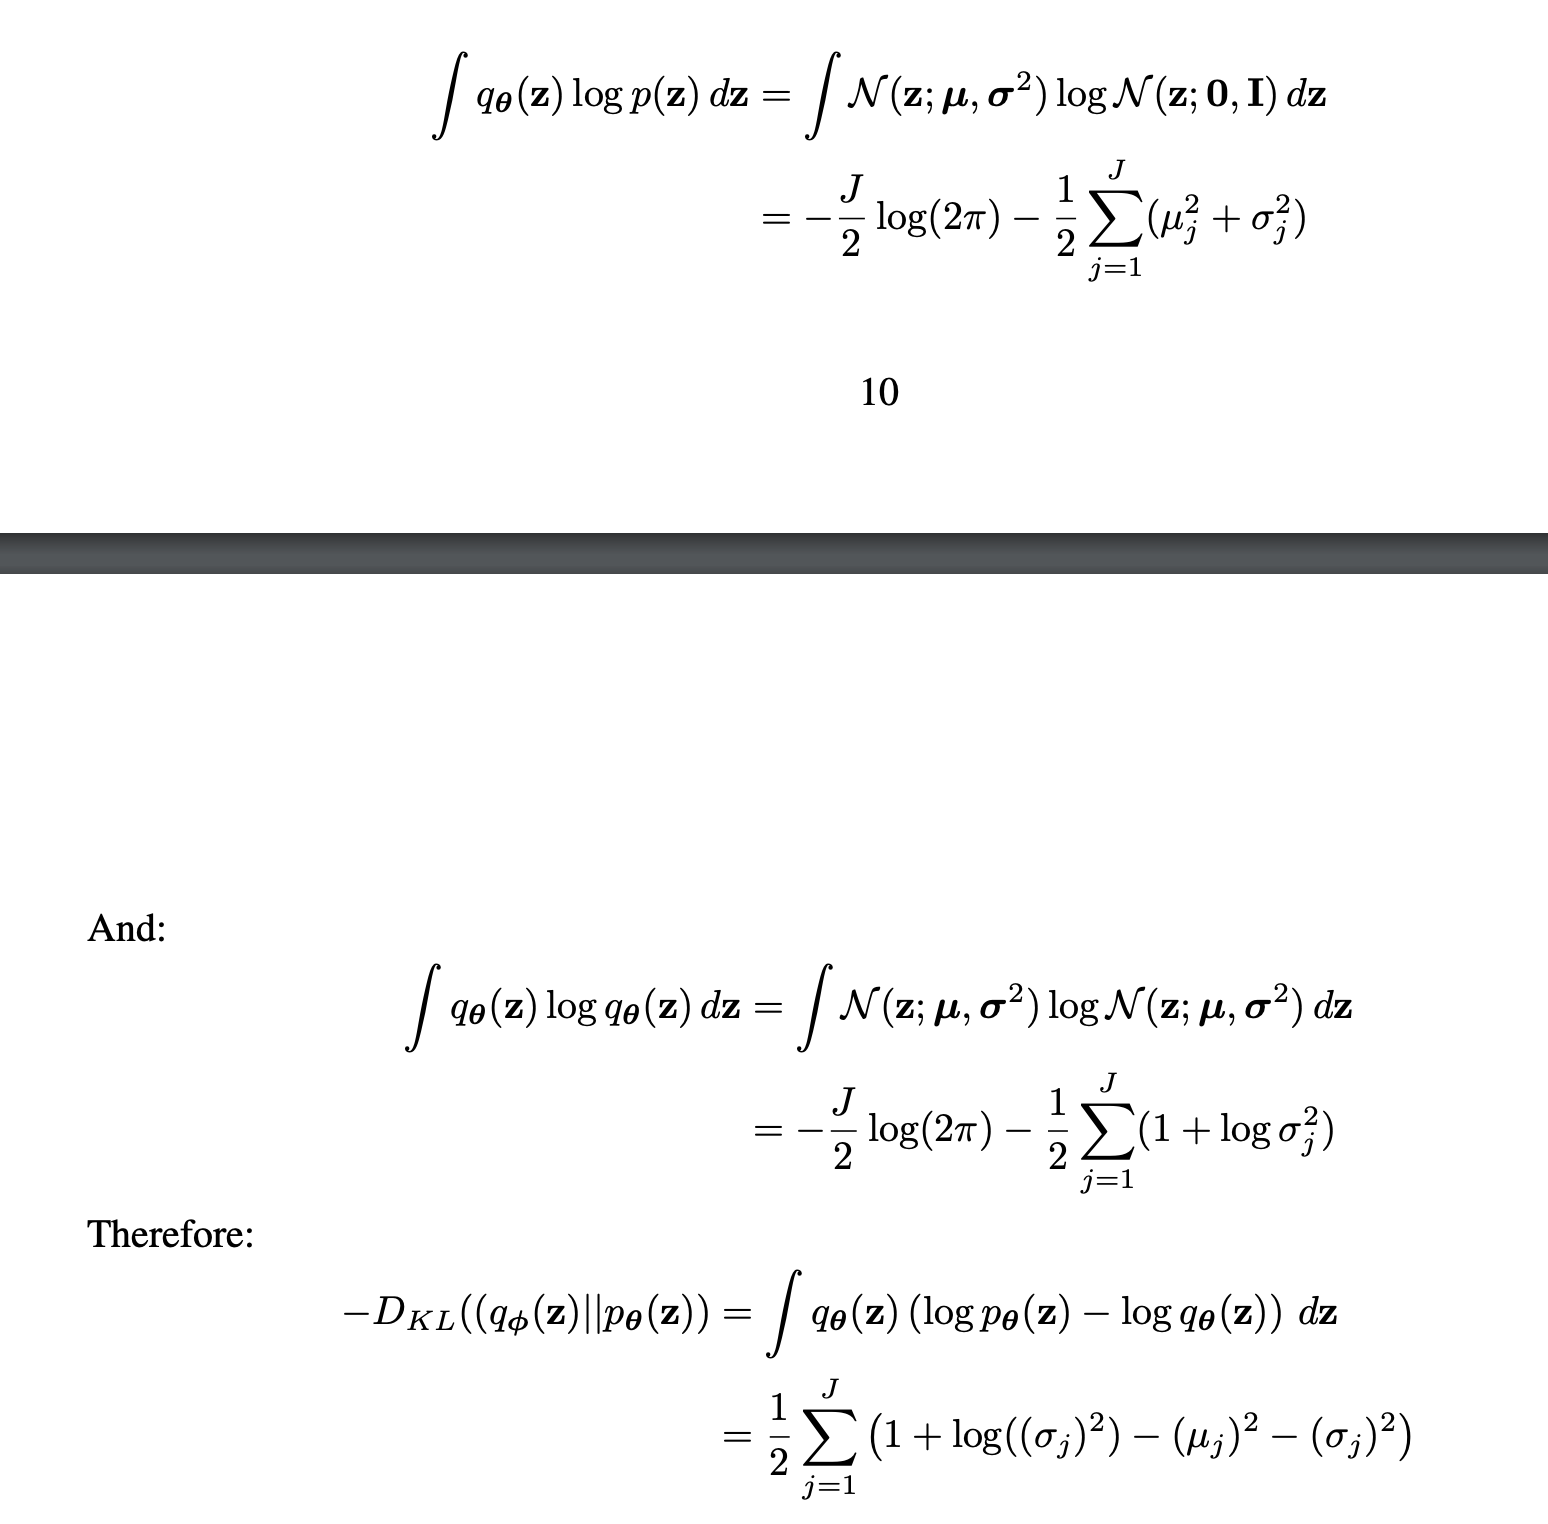

In [4]:
# https://arxiv.org/pdf/1312.6114.pdf
Image('../imgs/kl_loss.png', width=500)

### inference/generating

```
# 从标准正态分布中进行采样
z = torch.randn(batch_size, z_dim).to(device)
out = model.decode(z).view(-1, 1, 28, 28)
```

- 编码空间（潜在空间）通常是连续的，可以从潜在空间中随机采样并通过解码器生成新的图像。
    - samaple from a distribution
    

## coding

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [6]:
device

device(type='cuda')

In [69]:
# Hyper-parameters
image_size = 784   # 28*28
h_dim = 400
z_dim = 20
num_epochs = 20
batch_size = 128
learning_rate = 3e-4

In [44]:
# MNIST dataset
dataset = datasets.MNIST(root='../data', 
                         train=True, 
                         transform=transforms.ToTensor(), 
                         download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)
dataset[0][0].shape


torch.Size([1, 28, 28])

In [18]:
# FashionMNIST dataset
dataset = datasets.FashionMNIST(root='../data', 
                         train=True, 
                         transform=transforms.ToTensor(), 
                         download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)
dataset[0][0].shape

torch.Size([1, 28, 28])

In [71]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [72]:
for epoch in range(num_epochs):
    
    # training 
    for i, (x, _) in enumerate(data_loader):
        
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # 
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 200 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], total Loss: {:.4f}=Reconst Loss: {:.4f}+KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), 
                           loss.item(), reconst_loss.item(), kl_div.item()))
    
    # sampling/generating 
    with torch.no_grad():
        # 从标准正态分布中进行采样
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        # 16*8
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        # 16*16
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/20], Step [200/469], total Loss: 24082.4473=Reconst Loss: 22360.0859+KL Div: 1722.3622
Epoch[1/20], Step [400/469], total Loss: 20647.5879=Reconst Loss: 18391.4355+KL Div: 2256.1528
Epoch[2/20], Step [200/469], total Loss: 18420.6309=Reconst Loss: 15935.1064+KL Div: 2485.5249
Epoch[2/20], Step [400/469], total Loss: 17367.8945=Reconst Loss: 14756.8418+KL Div: 2611.0535
Epoch[3/20], Step [200/469], total Loss: 16349.3418=Reconst Loss: 13579.7969+KL Div: 2769.5447
Epoch[3/20], Step [400/469], total Loss: 15739.8711=Reconst Loss: 12830.4941+KL Div: 2909.3765
Epoch[4/20], Step [200/469], total Loss: 15962.2266=Reconst Loss: 12901.9717+KL Div: 3060.2549
Epoch[4/20], Step [400/469], total Loss: 15363.9492=Reconst Loss: 12430.2490+KL Div: 2933.7000
Epoch[5/20], Step [200/469], total Loss: 14942.4600=Reconst Loss: 11930.9248+KL Div: 3011.5352
Epoch[5/20], Step [400/469], total Loss: 15409.8242=Reconst Loss: 12255.2383+KL Div: 3154.5864
Epoch[6/20], Step [200/469], total Loss: 14408.492